<a href="https://www.kaggle.com/code/hongbotrn/fcir-v2-cancer?scriptVersionId=217837268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---------------------------------

In [19]:
!pip install -U scikit-fuzzy
!pip install dask[complete]
!pip install scikit-image


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Import các thư viện cần thiết 

In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd 
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skfuzzy import cmeans
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import skimage.io as io
import skimage.transform as transform
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, f1_score
import random
from tensorflow.keras.utils import to_categorical
import dask.array as da
from dask import delayed
import time
from multiprocessing import Pool, get_context
from pathlib import Path  
import dask
from dask.distributed import Client

# **1. Chuẩn bị dữ liệu**

In [22]:
# Tải và chuẩn hóa dữ liệu
train_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/train"
test_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/test"

# Đếm số lượng ảnh lành tính và ác tính trong tập train
benign_folder_train = os.path.join(train_folder, "benign")
malignant_folder_train = os.path.join(train_folder, "malignant")

# Lấy danh sách file
benign_images_train = os.listdir(benign_folder_train)
malignant_images_train = os.listdir(malignant_folder_train)

# Đếm số lượng ảnh
num_benign_train = len(benign_images_train)
num_malignant_train = len(malignant_images_train)

print(f"Số lượng hình ảnh lành tính trong tâp train: {num_benign_train}")
print(f"Số lượng hình ảnh ác tính trong tâp train: {num_malignant_train}")

print("==========================================================")

# Đếm số lượng ảnh lành tính và ác tính trong tập test
benign_folder_test = os.path.join(test_folder, "benign")
malignant_folder_test = os.path.join(test_folder, "malignant")

# Lấy danh sách file
benign_images_test = os.listdir(benign_folder_test)
malignant_images_test = os.listdir(malignant_folder_test)

# Đếm số lượng ảnh
num_benign_test = len(benign_images_test)
num_malignant_test = len(malignant_images_test)

print(f"Số lượng hình ảnh lành tính trong tâp test: {num_benign_test}")
print(f"Số lượng hình ảnh ác tính trong tâp test: {num_malignant_test}")

Số lượng hình ảnh lành tính trong tâp train: 371
Số lượng hình ảnh ác tính trong tâp train: 777
Số lượng hình ảnh lành tính trong tâp test: 176
Số lượng hình ảnh ác tính trong tâp test: 369


## Các Ảnh gốc có khối u lành tính trong tập train

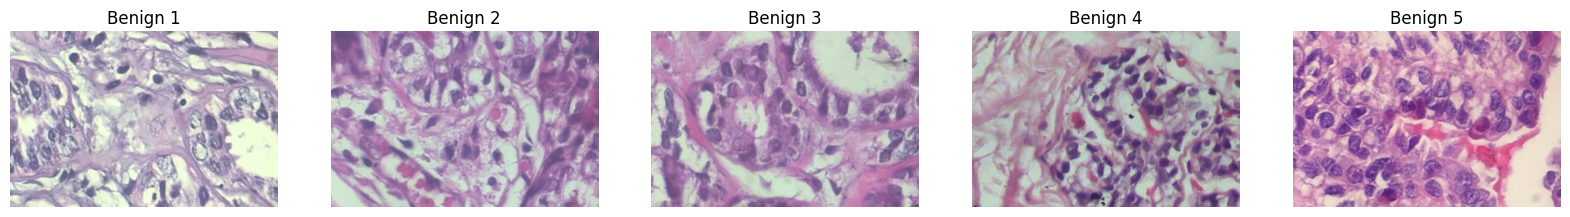

In [5]:
# Hiển thị một số ảnh minh họa lành tính (benign)
fig = plt.figure(figsize=(20, 4))
for index, file_name in enumerate(benign_images_train[:5]):  # Hiển thị tối đa 5 ảnh
    img_path = os.path.join(benign_folder_train, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        ax = fig.add_subplot(1, 5, index + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Benign {index + 1}")
    else:
        print(f"Failed to load image: {img_path}. Skipping...")

plt.show()

## Các ảnh gốc có khối u ác tính trong tập train

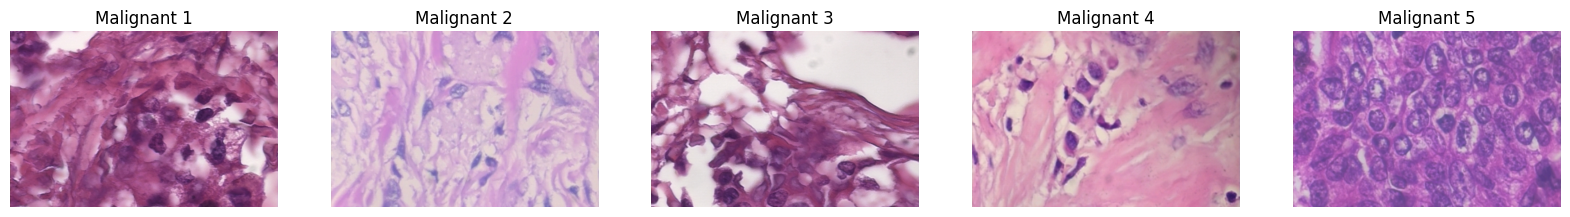

In [6]:
# Hiển thị một số ảnh minh họa ác tính (malignant)
fig = plt.figure(figsize=(20, 4))
for index, file_name in enumerate(malignant_images_train[:5]):  # Hiển thị tối đa 5 ảnh
    img_path = os.path.join(malignant_folder_train, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        ax = fig.add_subplot(1, 5, index + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Malignant {index + 1}")
    else:
        print(f"Failed to load image: {img_path}. Skipping...")

plt.show()

# **2. Phân đoạn ảnh bằng Fuzzy C-Means**

In [7]:
def compute_distances_dask(flat_image, centroids):  
    """Computes distances for each cluster using Dask for parallelization."""  
    flat_image_dask = da.from_array(flat_image, chunks="auto")  # Shape: (num_pixels, 1)  
    centroids_dask = da.from_array(centroids, chunks="auto")  # Shape: (num_clusters, 1)

    # Broadcasting to compute distances  
    flat_image_broadcasted = flat_image_dask[:, np.newaxis, :]  # Shape: (num_pixels, 1, 3)  
    centroids_broadcasted = centroids_dask[np.newaxis, :, :]  # Shape: (1, num_clusters, 3)  
    differences = flat_image_broadcasted - centroids_broadcasted  # Shape: (num_pixels, num_clusters, 3)  

    # Tính khoảng cách  
    distances = da.sqrt(da.sum(differences ** 2, axis=2))  # Compute along last axis  
    result = distances.compute()  # Chuyển đổi kết quả thành mảng numpy    
    return result.T  # Final shape: (num_pixels, num_clusters).T => (num_clusters, num_pixels) 

def fuzzy_c_means_dask(image, num_clusters=6, m=2, epsilon=1e-5, max_iter=1000):  
    """  
    Fuzzy C-Means clustering with Dask for parallelized computation.  
    """  
    start_time = time.time()  
    print("Starting Fuzzy C-Means...")  # Thêm thông báo bắt đầu   

    # Step 1: Chuẩn hóa hình ảnh  
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize to [0, 1]  
    flat_image = normalized_image.reshape(-1, 3)  # Shape: (num_pixels, 3)  
    num_pixels = flat_image.shape[0] 

    # Step 2: Khởi tạo ngẫu nhiên ma trận thành viên  
    np.random.seed(42)  
    u = np.random.rand(num_clusters, num_pixels)  
    u = u / np.sum(u, axis=0)  # Normalize membership probabilities  
    
    j_history = []  

    for iteration in range(max_iter):     
        # Step 3: Cập nhật tâm cụm  
        centroids = np.zeros((num_clusters, 3))  
        for i in range(num_clusters):  
            numerator = np.sum((u[i] ** m)[:, np.newaxis] * flat_image, axis=0)  # Shape: (3,)  
            denominator = np.sum(u[i] ** m)  # Scalar  
            centroids[i] = numerator / denominator  # Store in centroids[i]    

        # Step 4: Tính khoảng cách  
        distances = compute_distances_dask(flat_image, centroids)    
        
        # Step 5: Update membership probabilities  
        distances_safe = np.where(distances > 1e-10, distances, 1e-10)  # Tránh chia cho 0  
        inverse_distances = distances_safe ** (-2 / (m - 1))  
        new_u = inverse_distances / np.sum(inverse_distances, axis=0)  

        # Step 6: Tính hàm mục tiêu  
        j = np.sum((u ** m) * (distances ** 2))  
        j_history.append(j)
        
        # Step 7: Kiểm tra hội tụ  
        if iteration > 0 and abs(j_history[-1] - j_history[-2]) < epsilon:   
            break  
        u = new_u    

    # Step 9: Gán nhãn cụm  
    segmented_image = np.argmax(u, axis=0).reshape(image.shape[0:2])  # Shape: (height, width)  

    # In kích thước của flat_image và centroids để debug  
    print(f"flat_image shape: {flat_image.shape}, centroids shape: {centroids.shape}")
    print(f"Distances computed: {distances.shape}") # Debugging step
    print(f"Fuzzy C-Means completed in {time.time() - start_time:.2f} seconds.")  
    return segmented_image, u, j_history, centroids  # Return segmented image, membership matrix, history, and centroids  

def segment_images_dask(image_files, num_clusters=6, epsilon=1e-5, max_iter=1000, save_dir=None):  
    """Segments a list of images using FCM and saves results."""  
    segmented_results = []  
    for idx, image_path in enumerate(image_files):  
        if not os.path.isfile(image_path):  
            print(f"Invalid file: {image_path}. Skipping...")  
            continue  

        # Load image and resize  
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color directly  
        if image is None:  
            print(f"Failed to load image: {image_path}")  
            continue  

        resized_image = cv2.resize(image, (299, 299))  # Resize to 299x299  
        print(f"Segmenting image {idx + 1}/{len(image_files)}: {image_path}")  

        # Segment the color image using FCM  
        segmented_image, _, _, centroids = fuzzy_c_means_dask(  
            image=resized_image,  
            num_clusters=num_clusters,  
            epsilon=epsilon,  
            max_iter=max_iter  
        )  

        # Convert segmented image to color using the centroids  
        color_segmented_image = np.zeros_like(resized_image)  
        for cluster_idx in range(num_clusters):  
            color_segmented_image[segmented_image == cluster_idx] = centroids[cluster_idx] * 255  # Scale centroids to [0, 255]  

        segmented_results.append(color_segmented_image)  

        # Save segmented image  
        if save_dir is not None:  
            os.makedirs(save_dir, exist_ok=True)  
            save_path = os.path.join(save_dir, f"segmented_{idx + 1}.png")  
            cv2.imwrite(save_path, color_segmented_image.astype(np.uint8))  
            print(f"Saved segmented image: {save_path}")  # Log saving progress  

    return segmented_results 

def process_image(image_path, save_dir, num_clusters, epsilon, max_iter):  
    """Processes a single image with FCM and saves the segmented result."""  
    print(f"Start processing image: {image_path}")  
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load color image  
    if image is None:  
        print(f"Failed to load image: {image_path}")  
        return None  

    resized_image = cv2.resize(image, (299, 299))  # Resize to 299x299  
    segmented_image, _, _, centroids = fuzzy_c_means_dask(  
        image=resized_image, num_clusters=num_clusters, epsilon=epsilon, max_iter=max_iter  
    )  

    # Convert segmented image to color using centroids  
    color_segmented_image = np.zeros_like(resized_image)  
    for cluster_idx in range(num_clusters):  
        color_segmented_image[segmented_image == cluster_idx] = centroids[cluster_idx] * 255  

    # Save the segmented image  
    os.makedirs(save_dir, exist_ok=True)  
    save_path = os.path.join(save_dir, os.path.basename(image_path))  
    cv2.imwrite(save_path, color_segmented_image.astype(np.uint8))  
    print(f"Processed and saved: {save_path}")  # Log progress  
    return segmented_image  

def segment_images_parallel(image_folder, save_folder, num_clusters=6, epsilon=1e-5, max_iter=1000):  
    """  
    Segments all images in a folder using parallel processing.  
    """  
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]  
    print(f"Found {len(image_files)} images in {image_folder}.")  
    if not image_files:  
        print(f"No images found in {image_folder}. Skipping...")  
        return  

    # Use multiprocessing with spawn mode  
    num_processes = max(1, min(4, os.cpu_count() // 2))  
    with get_context("spawn").Pool(processes=num_processes) as pool:  
        pool.starmap(  
            process_image,  
            [(image_path, save_folder, num_clusters, epsilon, max_iter) for image_path in image_files]  
        )  
    print("Finished processing all images.")  

def train_and_test_dask(image_folder_train, image_folder_test, save_folder_train, save_folder_test, num_clusters=6, epsilon=1e-5, max_iter=1000):  
    """Runs the FCM segmentation pipeline on train and test datasets with Dask."""  
    os.makedirs(save_folder_train, exist_ok=True)  
    os.makedirs(save_folder_test, exist_ok=True)  

    train_image_files = [os.path.join(image_folder_train, f) for f in os.listdir(image_folder_train) if f.endswith(('.jpg', '.png'))]  
    print(f"Found {len(train_image_files)} training images.")  
    segment_images_dask(train_image_files, num_clusters, epsilon, max_iter, save_dir=save_folder_train)  

    test_image_files = [os.path.join(image_folder_test, f) for f in os.listdir(image_folder_test) if f.endswith(('.jpg', '.png'))]  
    print(f"Found {len(test_image_files)} testing images.")  
    segment_images_dask(test_image_files, num_clusters, epsilon, max_iter, save_dir=save_folder_test)  

## Phân đoạn ảnh benign cho 2 tập train và test 

In [17]:
# Run the pipeline
train_image_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/benign"
test_image_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign"
save_folder_train = "/kaggle/working/segmented_train/benign"
save_folder_test = "/kaggle/working/segmented_test/benign"

train_and_test_dask(train_image_folder, test_image_folder, save_folder_train, save_folder_test, num_clusters=6, epsilon=1e-5, max_iter=1000)  

Found 371 training images.
Segmenting image 1/371: /kaggle/input/breakhis-400x/BreaKHis 400X/train/benign/SOB_B_F-14-9133-400-011.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 6.07 seconds.
Saved segmented image: /kaggle/working/segmented_train/benign/segmented_1.png
Segmenting image 2/371: /kaggle/input/breakhis-400x/BreaKHis 400X/train/benign/SOB_B_A-14-22549G-400-018.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 4.54 seconds.
Saved segmented image: /kaggle/working/segmented_train/benign/segmented_2.png
Segmenting image 3/371: /kaggle/input/breakhis-400x/BreaKHis 400X/train/benign/SOB_B_A-14-22549G-400-008.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 5.68 seconds.
Saved segmented image: /kaggle/worki

----------------

## Phân đoạn ảnh malignant cho 2 tập train và test 

In [19]:
# Example usage
train_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant"
test_folder = "/kaggle/input/breakhis-400x/BreaKHis 400X/test/malignant"
save_folder_train = "/kaggle/working/segmented_train/malignant"
save_folder_test = "/kaggle/working/segmented_test/malignant"

train_and_test_dask(train_folder, test_folder, save_folder_train, save_folder_test, num_clusters=6, epsilon=1e-5, max_iter=1000)

Found 777 training images.
Segmenting image 1/777: /kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-16716-400-028.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 6.31 seconds.
Saved segmented image: /kaggle/working/segmented_train/malignant/segmented_1.png
Segmenting image 2/777: /kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-17901-400-013.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 5.83 seconds.
Saved segmented image: /kaggle/working/segmented_train/malignant/segmented_2.png
Segmenting image 3/777: /kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-16716-400-027.png
Starting Fuzzy C-Means...
flat_image shape: (89401, 3), centroids shape: (6, 3)
Distances computed: (6, 89401)
Fuzzy C-Means completed in 6.93 seconds.
Saved segmented ima

---------------

## Tải dữ liệu ảnh đã được phân đoạn 

In [8]:
train_folder = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train"
test_folder = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test"

# Đếm số lượng ảnh lành tính và ác tính trong tập train
benign_folder_train = os.path.join(train_folder, "benign")
malignant_folder_train = os.path.join(train_folder, "malignant")

# Lấy danh sách file
benign_images_train = os.listdir(benign_folder_train)
malignant_images_train = os.listdir(malignant_folder_train)

# Đếm số lượng ảnh
num_benign_train = len(benign_images_train)
num_malignant_train = len(malignant_images_train)

print(f"Số lượng hình ảnh lành tính đã được phân đoạn trong tâp train: {num_benign_train}")
print(f"Số lượng hình ảnh ác tính đã được phân đoạn trong tâp train: {num_malignant_train}")

print("==========================================================")

# Đếm số lượng ảnh lành tính và ác tính trong tập test
benign_folder_test = os.path.join(test_folder, "benign")
malignant_folder_test = os.path.join(test_folder, "malignant")

# Lấy danh sách file
benign_images_test = os.listdir(benign_folder_test)
malignant_images_test = os.listdir(malignant_folder_test)

# Đếm số lượng ảnh
num_benign_test = len(benign_images_test)
num_malignant_test = len(malignant_images_test)

print(f"Số lượng hình ảnh lành tính đã được phân đoạn trong tâp test: {num_benign_test}")
print(f"Số lượng hình ảnh ác tính đã được phân đoạn trong tâp test: {num_malignant_test}")

Số lượng hình ảnh lành tính đã được phân đoạn trong tâp train: 371
Số lượng hình ảnh ác tính đã được phân đoạn trong tâp train: 777
Số lượng hình ảnh lành tính đã được phân đoạn trong tâp test: 176
Số lượng hình ảnh ác tính đã được phân đoạn trong tâp test: 369


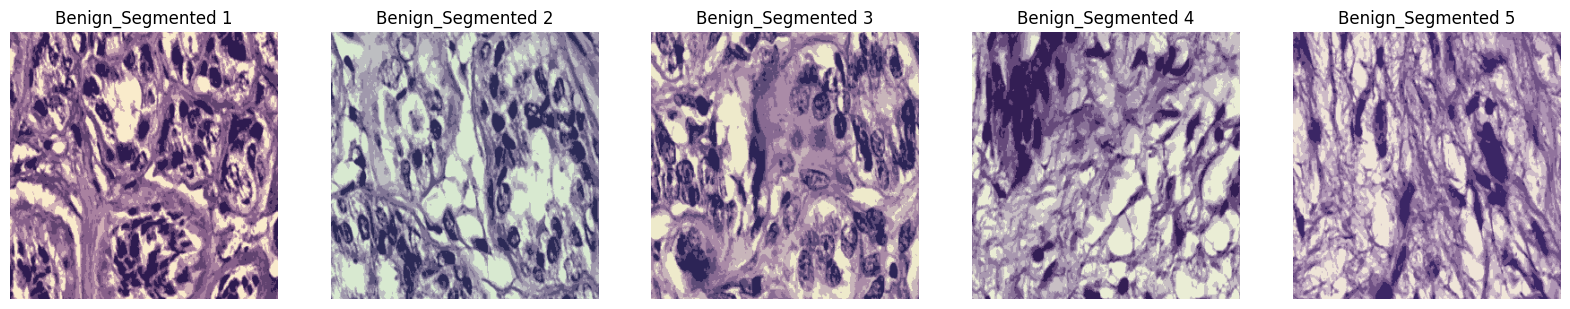

In [9]:
# Hiển thị một số ảnh minh họa lành tính đã được phân đoạn (benign)
fig = plt.figure(figsize=(20, 4))
for index, file_name in enumerate(benign_images_train[:5]):  # Hiển thị tối đa 5 ảnh
    img_path = os.path.join(benign_folder_train, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        ax = fig.add_subplot(1, 5, index + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Benign_Segmented {index + 1}")
    else:
        print(f"Failed to load image: {img_path}. Skipping...")

plt.show()

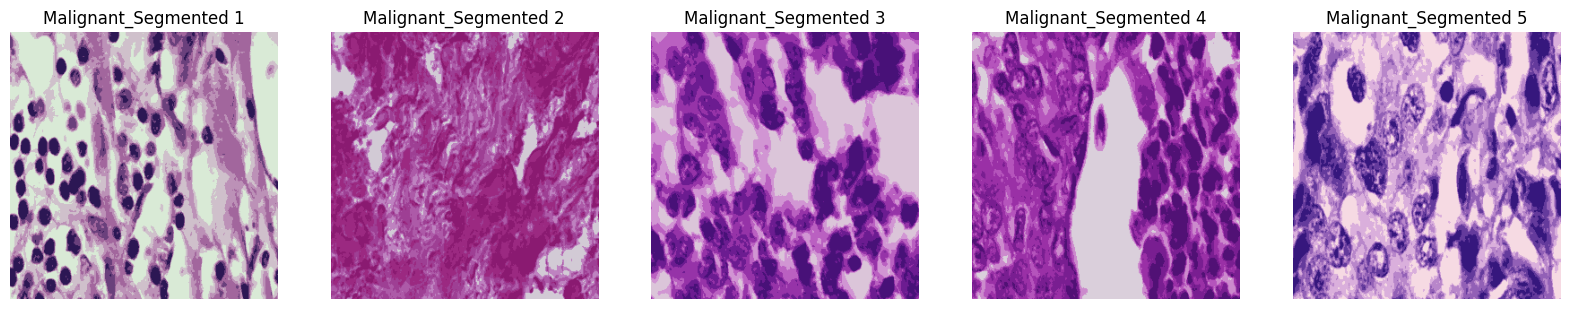

In [11]:
# Hiển thị một số ảnh minh họa ác tính đã được phân đoạn (malignant)
fig = plt.figure(figsize=(20, 4))
for index, file_name in enumerate(malignant_images_train[:5]):  # Hiển thị tối đa 5 ảnh
    img_path = os.path.join(malignant_folder_train, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        ax = fig.add_subplot(1, 5, index + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Malignant_Segmented {index + 1}")
    else:
        print(f"Failed to load image: {img_path}. Skipping...")

plt.show()

# **3. Tính Hội Tụ Của Thuật Toán**

In [12]:
def compute_distances_dask(flat_image, centroids):  
    """Computes distances for each cluster using Dask for parallelization."""  
    flat_image_dask = da.from_array(flat_image, chunks="auto")  # Shape: (num_pixels, 1)  
    centroids_dask = da.from_array(centroids, chunks="auto")  # Shape: (num_clusters, 1)

    # Broadcasting to compute distances  
    flat_image_broadcasted = flat_image_dask[:, np.newaxis, :]  # Shape: (num_pixels, 1, 3)  
    centroids_broadcasted = centroids_dask[np.newaxis, :, :]  # Shape: (1, num_clusters, 3)  
    differences = flat_image_broadcasted - centroids_broadcasted  # Shape: (num_pixels, num_clusters, 3)  

    # Tính khoảng cách  
    distances = da.sqrt(da.sum(differences ** 2, axis=2))  # Compute along last axis  
    result = distances.compute()  # Chuyển đổi kết quả thành mảng numpy    
    return result.T  # Final shape: (num_pixels, num_clusters).T => (num_clusters, num_pixels) 

def fuzzy_c_means_dask(image, num_clusters=6, m=2, epsilon=1e-5, max_iter=1000):  
    """  
    Fuzzy C-Means clustering with Dask for parallelized computation.  
    """  
    start_time = time.time()  
    print("Starting Fuzzy C-Means...")  # Thêm thông báo bắt đầu   

    # Step 1: Chuẩn hóa hình ảnh  
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize to [0, 1]  
    flat_image = normalized_image.reshape(-1, 3)  # Shape: (num_pixels, 3)  
    num_pixels = flat_image.shape[0] 

    # Step 2: Khởi tạo ngẫu nhiên ma trận thành viên  
    np.random.seed(42)  
    u = np.random.rand(num_clusters, num_pixels)  
    u = u / np.sum(u, axis=0)  # Normalize membership probabilities  
    
    j_history = []  

    for iteration in range(max_iter):     
        # Step 3: Cập nhật tâm cụm  
        centroids = np.zeros((num_clusters, 3))  
        for i in range(num_clusters):  
            numerator = np.sum((u[i] ** m)[:, np.newaxis] * flat_image, axis=0)  # Shape: (3,)  
            denominator = np.sum(u[i] ** m)  # Scalar  
            centroids[i] = numerator / denominator  # Store in centroids[i]    

        # Step 4: Tính khoảng cách  
        distances = compute_distances_dask(flat_image, centroids)    
        
        # Step 5: Update membership probabilities  
        distances_safe = np.where(distances > 1e-10, distances, 1e-10)  # Tránh chia cho 0  
        inverse_distances = distances_safe ** (-2 / (m - 1))  
        new_u = inverse_distances / np.sum(inverse_distances, axis=0)  

        # Step 6: Tính hàm mục tiêu  
        j = np.sum((u ** m) * (distances ** 2))  
        j_history.append(j)
        
        # Step 7: Kiểm tra hội tụ  
        if iteration > 0 and abs(j_history[-1] - j_history[-2]) < epsilon:   
            break  
        u = new_u    

    # Step 9: Gán nhãn cụm  
    segmented_image = np.argmax(u, axis=0).reshape(image.shape[0:2])  # Shape: (height, width)  

    # In kích thước của flat_image và centroids để debug  
    print(f"Fuzzy C-Means completed in {time.time() - start_time:.2f} seconds.")  
    return segmented_image, u, j_history, centroids  # Return segmented image, membership matrix, history, and centroids  

# Hàm vẽ và lưu đồ thị hội tụ
def save_convergence_plot(j_history, save_dir, image_name):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 6))
    plt.plot(j_history, label="Objective Function J", marker="o", linestyle="-")
    plt.title(f"Convergence of FCM for {image_name}")
    plt.xlabel("Iterations")
    plt.ylabel("Objective Function (J)")
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, f"{image_name}_convergence.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Saved convergence plot: {save_path}")


# Hàm lưu lịch sử hội tụ dưới dạng CSV
def save_convergence_csv(j_history, save_dir, image_name):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{image_name}_convergence.csv")
    df = pd.DataFrame({
        "Iteration": range(1, len(j_history) + 1),
        "Objective Function (J)": j_history
    })
    df.to_csv(save_path, index=False)
    print(f"Saved convergence history to: {save_path}")


# Hàm tính toán hội tụ cho từng ảnh
def process_image_with_convergence(image_path, save_dir, num_clusters, epsilon, max_iter):  
    print(f"Start processing image: {image_path}")  
    try:  
        # Read the color image  
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  
        if image is None:  
            print(f"Cannot load image: {image_path}. Ensure the file exists and is valid.")  
            return  

        # Resize the image  
        resized_image = cv2.resize(image, (299, 299))  

        # Segment the image using Fuzzy C-Means  
        segmented_image, _, j_history, centroids = fuzzy_c_means_dask(  
            image=resized_image, num_clusters=num_clusters, epsilon=epsilon, max_iter=max_iter  
        )  

        # Convert segmented image back to color  
        color_segmented_image = np.zeros_like(resized_image)  
        for cluster_idx in range(num_clusters):  
            color_segmented_image[segmented_image == cluster_idx] = centroids[cluster_idx] * 255  

        # Save convergence plot and CSV  
        save_convergence_plot(j_history, save_dir, Path(image_path).stem)  
        save_convergence_csv(j_history, save_dir, Path(image_path).stem)  

        # Save the segmented image  
        save_path = os.path.join(save_dir, f"{Path(image_path).stem}_segmented.png")  
        cv2.imwrite(save_path, color_segmented_image.astype(np.uint8))  
        print(f"Processed and saved: {save_path}")  

        # Return the result for visualization  
        return {  
            "image_path": image_path,  
            "segmented_image": color_segmented_image,  
            "final_iteration_image": color_segmented_image,  # In this case it’s the same for demo; adjust if different  
            "j_history": j_history,  
            "final_objective_value": j_history[-1],  
            "converged": len(j_history) < max_iter  # Example convergence check  
        }  

    except Exception as e:  
        print(f"Error processing {image_path}: {str(e)}")  

# Hàm tính toán hội tụ cho toàn bộ dataset
def process_convergence_for_dataset(image_folder, save_dir, num_clusters=6, epsilon=1e-5, max_iter=1000):  
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]  
    print(f"Found {len(image_files)} images in {image_folder}.")  

    results = []  # Collect results for visualization  
    for idx, image_path in enumerate(image_files):  
        result = process_image_with_convergence(image_path, save_dir, num_clusters, epsilon, max_iter)  
        if result:  # Ensure we only append valid results  
            results.append(result)  

    return results  # Return the list of results    

# Hàm xử lý Fuzzy C-Means song song với Dask
def run_fuzzy_c_means_on_dataset(image_files, num_clusters=6, epsilon=1e-5, max_iter=1000):  
    client = Client()  
    tasks = [  
        dask.delayed(process_image_with_convergence)(  
            image_files[idx], save_dir='', num_clusters=num_clusters, epsilon=epsilon, max_iter=max_iter  
        )  
        for idx in range(len(image_files))  
    ]  
    results = dask.compute(*tasks)  
    client.close()  
    return results  

# Hàm trực quan hóa kết quả hội tụ
def visualize_results(results):  
    # Limit to a maximum of 2 visualizations  
    max_visualizations = 2  
    for idx, result in enumerate(results):  
        # Stop if we have displayed the maximum number of visualizations  
        if idx >= max_visualizations:  
            break  
        
        # Create a new figure for each image result  
        plt.figure(figsize=(12, 6))  

        # Display segmented image  
        plt.subplot(1, 2, 1)  
        plt.imshow(result["segmented_image"], cmap='jet')  
        plt.title("Segmented Image (Final Iteration)")  
        plt.axis('off')  

        # Display original image  
        original_image = cv2.imread(result["image_path"], cv2.IMREAD_COLOR)  
        if original_image is None:  
            print(f"Error loading original image: {result['image_path']}")  
            continue  
        
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB  
        plt.subplot(1, 2, 2)  
        plt.imshow(original_image_rgb)  
        plt.title("Original Image")  
        plt.axis('off')  
        
        plt.show()  

        # Plot convergence history  
        plt.figure()  
        plt.plot(result["j_history"], marker='o')  
        plt.title("Convergence of Objective Function")  
        plt.xlabel("Iterations")  
        plt.ylabel("Objective Function Value")  
        plt.grid()  
        plt.show()  

        print(f"Image: {result['image_path']}, Final Objective Value: {result['final_objective_value']:.5f}, Converged: {result['converged']}")  

## Xử lý hội tụ cho tập train và test của lành tính

In [23]:
# Đường dẫn dữ liệu phân đoạn
train_folder_benign = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign"
test_folder_benign = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/benign"

# Đường dẫn lưu kết quả hội tụ
save_dir_train = "/kaggle/working/convergence_train/benign"
save_dir_test = "/kaggle/working/convergence_test/benign"

# Xử lý hội tụ cho tập train
train_results_benign = process_convergence_for_dataset(train_folder_benign, save_dir_train, num_clusters=6, epsilon=1e-5, max_iter=1000)  

# Xử lý hội tụ cho tập test
test_results_benign = process_convergence_for_dataset(test_folder_benign, save_dir_test, num_clusters=6, epsilon=1e-5, max_iter=1000)  

Found 371 images in /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign.
Start processing image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign/segmented_123.png
Starting Fuzzy C-Means...
Fuzzy C-Means completed in 1.00 seconds.
Saved convergence plot: /kaggle/working/convergence_train/benign/segmented_123_convergence.png
Saved convergence history to: /kaggle/working/convergence_train/benign/segmented_123_convergence.csv
Processed and saved: /kaggle/working/convergence_train/benign/segmented_123_segmented.png
Start processing image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign/segmented_248.png
Starting Fuzzy C-Means...
Fuzzy C-Means completed in 4.19 seconds.
Saved convergence plot: /kaggle/working/convergence_train/benign/segmented_248_convergence.png
Saved convergence history to: /kaggle/working/convergence_train/benign/segmented_248_convergence.csv
Processed and saved: /kaggle/working/convergence_train

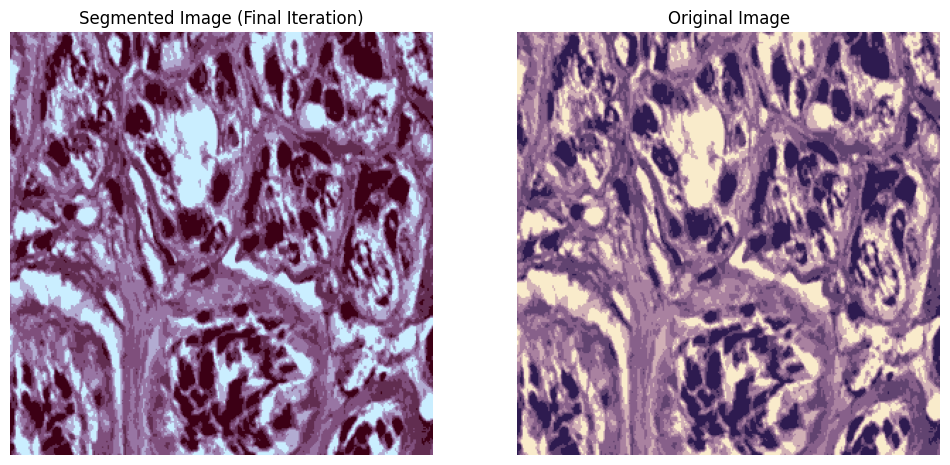

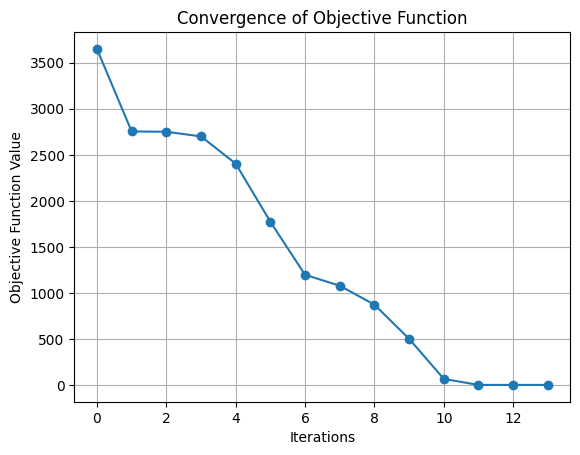

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign/segmented_123.png, Final Objective Value: 0.00000, Converged: True


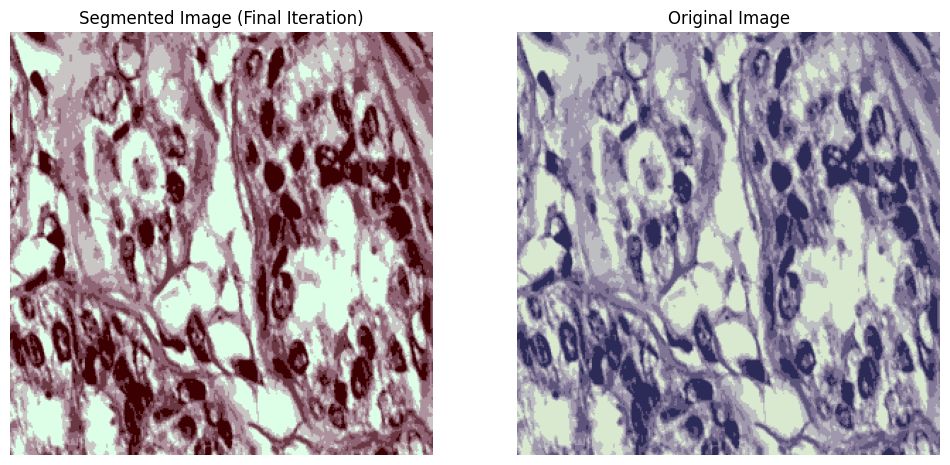

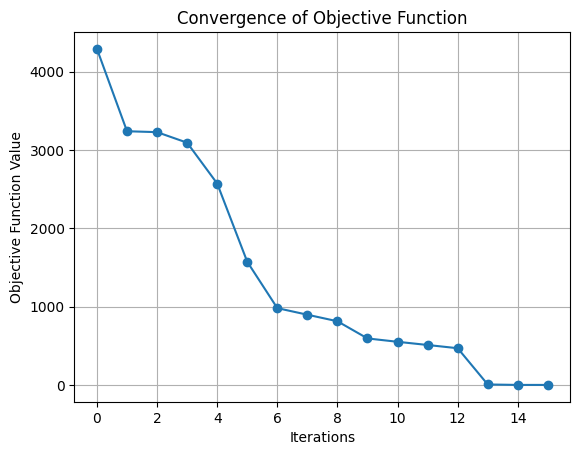

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/benign/segmented_248.png, Final Objective Value: 0.00000, Converged: True


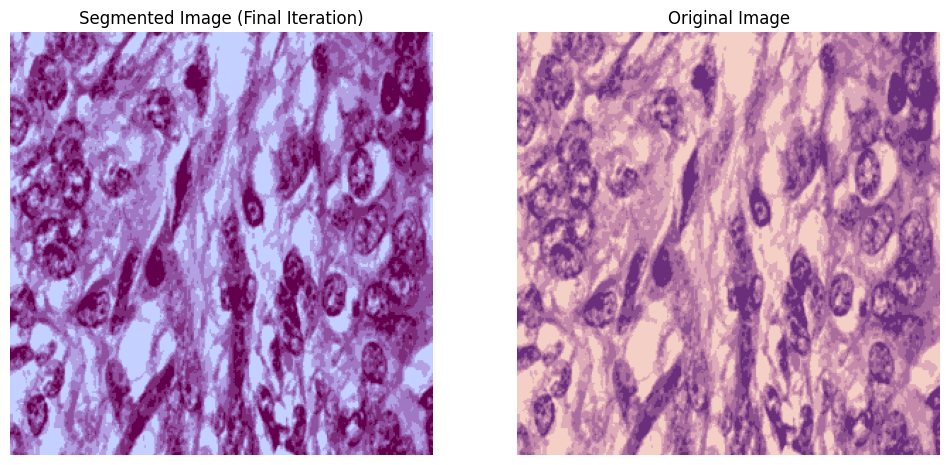

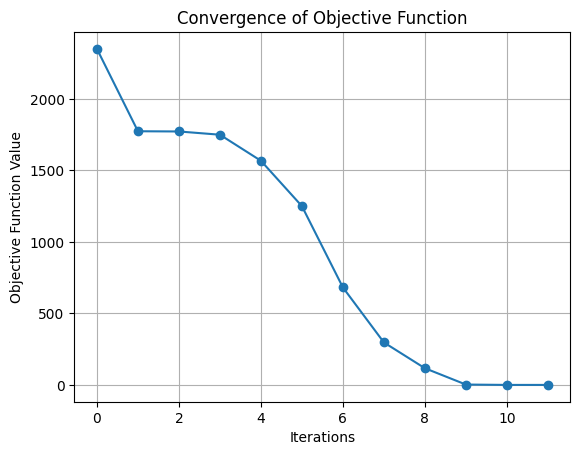

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/benign/segmented_123.png, Final Objective Value: 0.00000, Converged: True


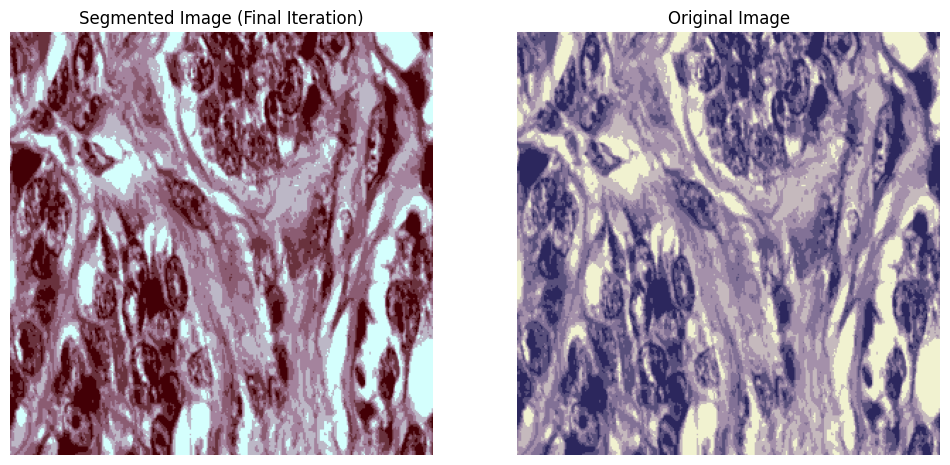

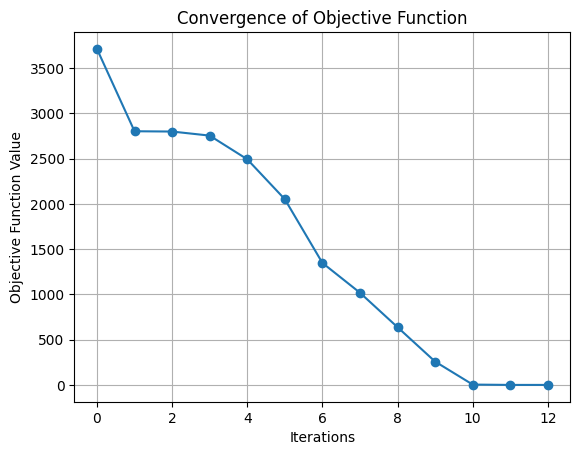

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/benign/segmented_14.png, Final Objective Value: 0.00000, Converged: True


In [24]:
# Visualize the results for training dataset  
visualize_results(train_results_benign)  
# Visualize the results for testing dataset  
visualize_results(test_results_benign) 

## Xử lý hội tụ cho tập train và test của ác tính

In [13]:
# Đường dẫn dữ liệu phân đoạn
train_folder_malignant = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant"
test_folder_malignant = "/kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/malignant"

# Đường dẫn lưu kết quả hội tụ
save_dir_train = "/kaggle/working/convergence_train/malignant"
save_dir_test = "/kaggle/working/convergence_test/malignant"

# Xử lý hội tụ cho tập train
train_results_malignant = process_convergence_for_dataset(train_folder_malignant, save_dir_train, num_clusters=6, epsilon=1e-5, max_iter=1000)  

# Xử lý hội tụ cho tập test
test_results_malignant = process_convergence_for_dataset(test_folder_malignant, save_dir_test, num_clusters=6, epsilon=1e-5, max_iter=1000)  

Found 777 images in /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant.
Start processing image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant/segmented_123.png
Starting Fuzzy C-Means...
Fuzzy C-Means completed in 1.13 seconds.
Saved convergence plot: /kaggle/working/convergence_train/malignant/segmented_123_convergence.png
Saved convergence history to: /kaggle/working/convergence_train/malignant/segmented_123_convergence.csv
Processed and saved: /kaggle/working/convergence_train/malignant/segmented_123_segmented.png
Start processing image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant/segmented_248.png
Starting Fuzzy C-Means...
Fuzzy C-Means completed in 1.06 seconds.
Saved convergence plot: /kaggle/working/convergence_train/malignant/segmented_248_convergence.png
Saved convergence history to: /kaggle/working/convergence_train/malignant/segmented_248_convergence.csv
Processed and saved: /kaggle/w

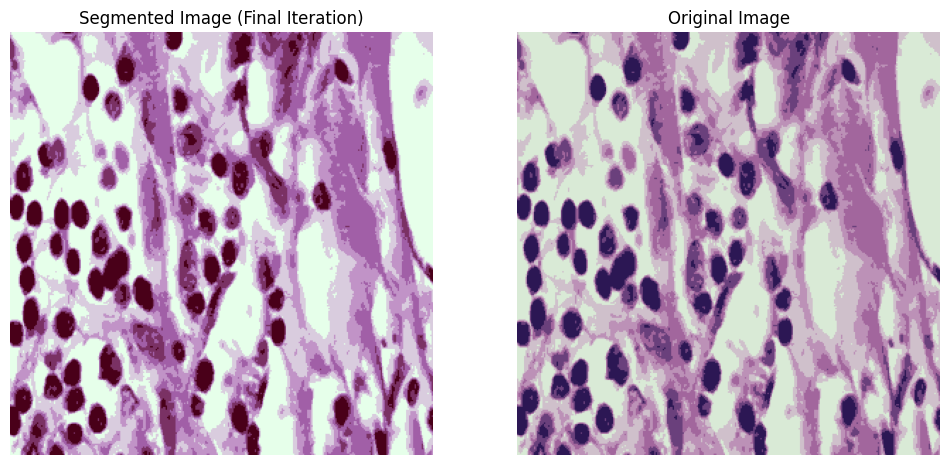

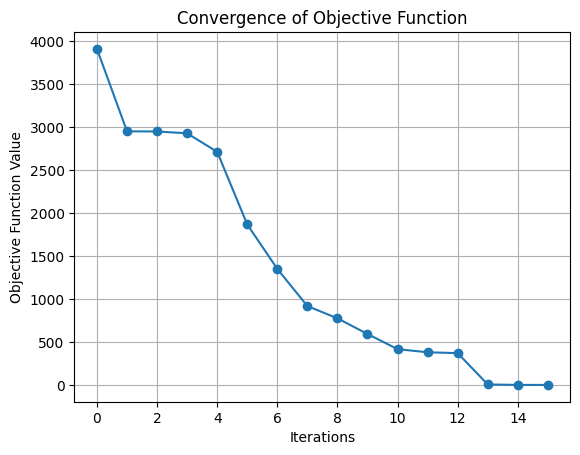

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant/segmented_123.png, Final Objective Value: 0.00000, Converged: True


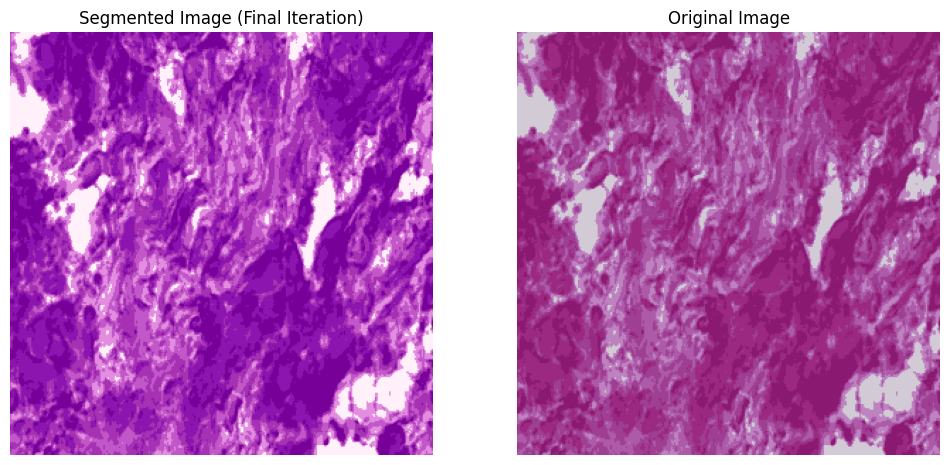

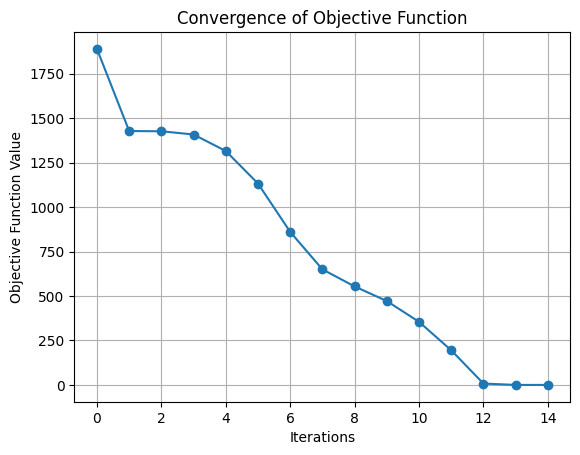

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_train/malignant/segmented_248.png, Final Objective Value: 0.00000, Converged: True


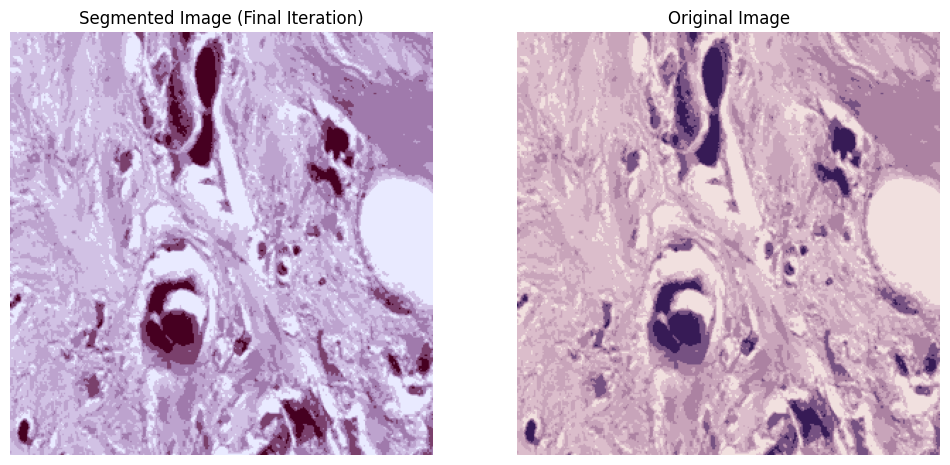

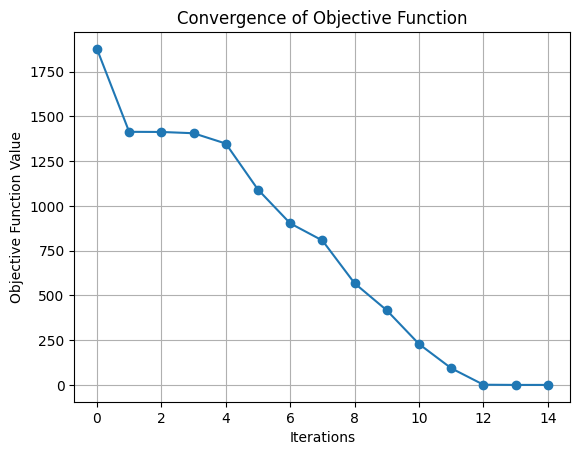

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/malignant/segmented_123.png, Final Objective Value: 0.00000, Converged: True


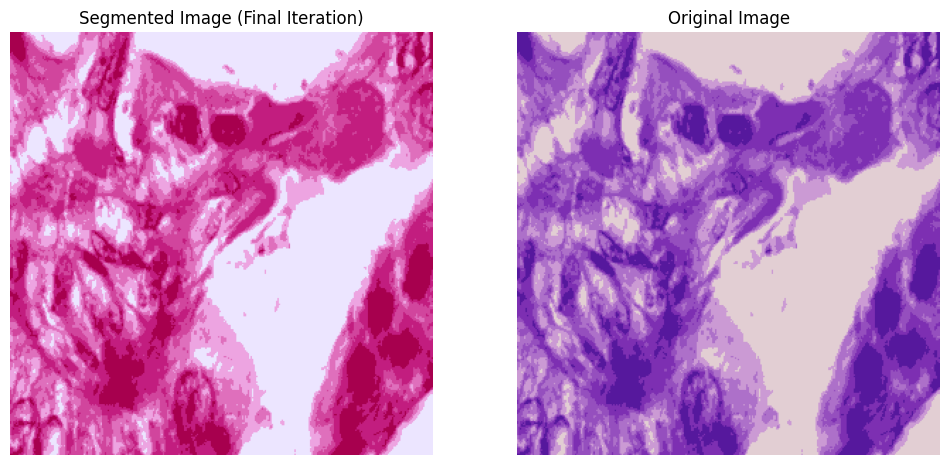

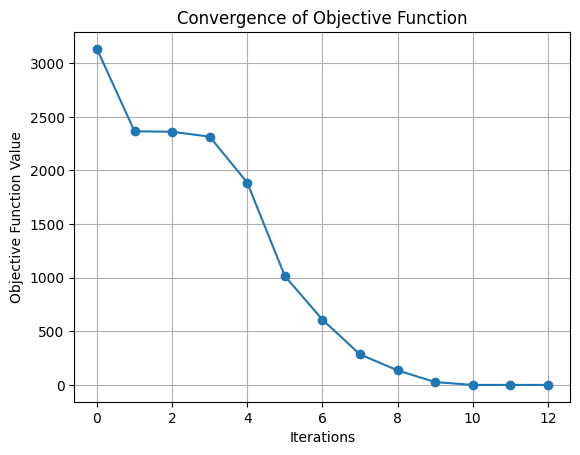

Image: /kaggle/input/breakhis-segmented/BreaKHis-Segmented/segmented_test/malignant/segmented_248.png, Final Objective Value: 0.00000, Converged: True


In [14]:
# Visualize the results for training dataset  
visualize_results(train_results_malignant)  
# Visualize the results for testing dataset  
visualize_results(test_results_malignant) 

In [25]:
import shutil

# Nén thư mục segmented_train
shutil.make_archive('/kaggle/working/convergence_train/benign', 'zip', '/kaggle/working/convergence_train/benign')

# Nén thư mục segmented_test
shutil.make_archive('/kaggle/working/convergence_test/benign', 'zip', '/kaggle/working/convergence_test/benign')


'/kaggle/working/convergence_test/benign.zip'

# **4. Tích hợp FCM và Inception ResNet-V2**

In [ ]:
def preprocess_and_segment_images(image_folder, num_clusters=3, epsilon=1e-5, max_iter=100):
    """
    Preprocesses and segments all images in a folder using fuzzy_c_means_with_convergence.
    Returns processed data and labels.
    
    Parameters:
    - image_folder: str, path to the folder containing class subfolders with images.
    - num_clusters: int, number of clusters for Fuzzy C-Means segmentation.
    - epsilon: float, convergence threshold for FCM.
    - max_iter: int, maximum number of iterations for FCM.
    
    Returns:
    - images_original: np.array, original images resized to (299, 299).
    - images_segmented: np.array, segmented images resized to (299, 299).
    - labels: np.array, one-hot encoded class labels.
    """
    images_original = []
    images_segmented = []
    labels = []
    class_names = sorted(os.listdir(image_folder))  # Get class subfolder names
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            
            # Load and resize the original image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Failed to load image: {image_path}")
                continue
            image_resized = cv2.resize(image, (299, 299))
            images_original.append(image_resized)
            
            # Perform segmentation using FCM improved
            segmented_image, _, _, _ = fuzzy_c_means_with_convergence(
                image=image_resized,
                num_clusters=num_clusters,
                epsilon=epsilon,
                max_iter=max_iter
            )
            images_segmented.append(segmented_image)
            
            # Add label
            labels.append(class_to_idx[class_name])
    
    # Normalize images to [0, 1]
    images_original = np.array(images_original).astype("float32") / 255.0
    images_segmented = np.array(images_segmented).astype("float32") / num_clusters  # Normalize segmented clusters
    labels = to_categorical(labels, num_classes=len(class_names))
    
    # Expand dimensions for CNN compatibility
    images_original = np.expand_dims(images_original, axis=-1)  # Shape: (N, 299, 299, 1)
    images_segmented = np.expand_dims(images_segmented, axis=-1)  # Shape: (N, 299, 299, 1)
    
    return images_original, images_segmented, labels

In [ ]:
# Preprocess dữ liệu
print("Preprocessing training data...")
train_original, train_segmented, train_labels = preprocess_and_segment_images(
    image_folder=train_folder,
    num_clusters=3,
    epsilon=1e-5,
    max_iter=50
)

print("Preprocessing validation data...")
val_original, val_segmented, val_labels = preprocess_and_segment_images(
    image_folder=val_folder,
    num_clusters=3,
    epsilon=1e-5,
    max_iter=50
)

print("Preprocessing test data...")
test_original, test_segmented, test_labels = preprocess_and_segment_images(
    image_folder=test_folder,
    num_clusters=3,
    epsilon=1e-5,
    max_iter=50
)

print("Preprocessing complete!")

In [ ]:
print(f"Train Original Shape: {train_original.shape}")
print(f"Train Segmented Shape: {train_segmented.shape}")
print(f"Train Labels Shape: {train_labels.shape}")

print(f"Validation Original Shape: {val_original.shape}")
print(f"Validation Segmented Shape: {val_segmented.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")

print(f"Test Original Shape: {test_original.shape}")
print(f"Test Segmented Shape: {test_segmented.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

# **5. Xây dựng mô hình Inception ResNet-V2**

In [ ]:
def build_combined_model(input_shape_original=(299, 299, 1), input_shape_segmented=(299, 299, 1), num_classes=2):
    """
    Builds a combined model using InceptionResNetV2 and FCM-segmented inputs.
    
    Parameters:
    - input_shape_original: tuple, shape of the original image input.
    - input_shape_segmented: tuple, shape of the segmented image input.
    - num_classes: int, number of output classes.
    
    Returns:
    - model: compiled Keras model.
    """
    # Load InceptionResNetV2 for original image processing
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
    # Input layers
    input_original = Input(shape=input_shape_original, name="original_input")
    input_segmented = Input(shape=input_shape_segmented, name="segmented_input")
    
    # Process original image through InceptionResNetV2
    processed_original = base_model(input_original)
    processed_original = GlobalAveragePooling2D()(processed_original)
    
    # Flatten segmented input
    flattened_segmented = Flatten()(input_segmented)
    
    # Combine both inputs
    concatenated = Concatenate()([processed_original, flattened_segmented])
    
    # Add Dense layers
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated) # Lớp fully connected, Thêm L2 regularization vào lớp Dense
    x = Dropout(0.8)(x) # Dropout giảm quá khớp
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.8)(x)
    output = Dense(num_classes, activation='softmax', name="output", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Build and compile model
    model = Model(inputs=[input_original, input_segmented], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-8),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Xây dựng mô hình
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) # Khởi tạo mạng Inception ResNet-V2

input_original = Input(shape=(299, 299, 3), name='original_input')
processed_original = base_model(input_original)
processed_original = GlobalAveragePooling2D()(processed_original) # Khối Global Average Pooling

input_segmented = Input(shape=(299, 299, 1), name='segmented_input')
flattened_segmented = Flatten()(input_segmented)

# Kết hợp đầu vào
concatenated = Concatenate()([processed_original, flattened_segmented])
## Dense Layers: Thêm một lớp Dense 1024 nơ-ron với ReLU và một lớp Softmax để phân loại 2 lớp.
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated) # Lớp fully connected, Thêm L2 regularization vào lớp Dense
x = Dropout(0.8)(x) # Dropout giảm quá khớp
predictions = Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # Lớp đầu ra với Softmax với L2 regularization

model = Model(inputs=[input_original, input_segmented], outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-8), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
model.summary()

In [ ]:
# Trực quan hóa mô hình và lưu thành file PNG
plot_model(model, to_file='model_Inception_ResNet_V2.png', show_shapes=True, show_layer_names=True)

# Hiển thị hình ảnh trong notebook
Image('model_Inception_ResNet_V2.png')

# **5. Huấn luyện mô hình**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Chuẩn bị dữ liệu đầu vào cho huấn luyện
train_original = np.array([item[0] for item in train_preprocessed])
train_segmented = np.expand_dims(np.array([item[1] for item in train_preprocessed]), axis=-1)
val_original = np.array([item[0] for item in val_preprocessed])
val_segmented = np.expand_dims(np.array([item[1] for item in val_preprocessed]), axis=-1)

history = model.fit(
    [train_original, train_segmented], train_labels,
    validation_data=([val_original, val_segmented], val_labels),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

# **5. Trực quan hóa đường cong Learning**

In [ ]:
# Lấy dữ liệu từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

# Vẽ Learning Curve
plt.figure(figsize=(12, 6))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **6. Trực quan hóa đặc trưng khối Stem**

In [ ]:
# Trích xuất đặc trưng từ khối Stem
stem_layer_name = "conv2d_609"  # Thay tên này bằng lớp Stem phù hợp từ danh sách
stem_model = Model(inputs=base_model.input, outputs=base_model.get_layer(stem_layer_name).output)

# Chuẩn bị ảnh để dự đoán
sample_image = test_original[0:1]  # Lấy một ảnh từ tập kiểm tra
stem_features = stem_model.predict(sample_image)

# Hiển thị ảnh gốc
plt.figure(figsize=(5, 5))
plt.imshow(sample_image[0])
plt.title("Original Image")
plt.axis('off')
plt.show()

# Hiển thị đặc trưng
plt.figure(figsize=(10, 10))
for i in range(16):  # Hiển thị 16 đặc trưng đầu tiên
    plt.subplot(4, 4, i + 1)
    plt.imshow(stem_features[0, :, :, i], cmap='jet')
    plt.axis('off')
plt.suptitle("Feature Maps from Stem Block", fontsize=16)
plt.show()


# **7. Trực quan hóa đặc trưng khối Inception ResNet C**

In [ ]:
# Trích xuất đặc trưng từ khối Inception ResNet C
ir_c_model = Model(inputs=model.input, outputs=base_model.get_layer("block17_1_conv").output)  
ir_c_features = ir_c_model.predict(sample_image)

# Hiển thị đặc trưng
plt.figure(figsize=(10, 10))
for i in range(16):  # Hiển thị 16 đặc trưng đầu tiên
    plt.subplot(4, 4, i + 1)
    plt.imshow(ir_c_features[0, :, :, i], cmap='jet')
    plt.axis('off')
plt.suptitle("Feature Maps from Inception ResNet C Block", fontsize=16)
plt.show()

# **8. Đánh giá tổng quan và trực quan hóa ma trận nhầm lẫn**

In [ ]:
# Đánh giá mô hình
test_preprocessed = preprocess_with_fcm(test_data)
test_original = np.array([item[0] for item in test_preprocessed])
test_segmented = np.expand_dims(np.array([item[1] for item in test_preprocessed]), axis=-1)
test_labels = test_data.labels

test_loss, test_acc = model.evaluate([test_original, test_segmented], tf.keras.utils.to_categorical(test_labels))
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc * 100:.2f}%")

# Đánh giá chi tiết
predictions = model.predict([test_original, test_segmented])
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc * 100:.2f}%")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_data.class_indices.keys()))

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# **2. Trực quan hóa dự đoán trên một batch**
batch_images, batch_labels = next(val_data)  # Lấy batch dữ liệu
batch_images = batch_images[:4]  # Lấy 4 hình ảnh đầu tiên
batch_labels = batch_labels[:4]  # Lấy nhãn của 4 hình ảnh đầu tiên

# Dự đoán trên batch
predictions = model.predict(batch_images)  # Dự đoán
predicted_labels = np.argmax(predictions, axis=1)  # Lấy nhãn dự đoán

# Hiển thị hình ảnh với nhãn thực và dự đoán
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
class_names = ['Benign', 'Malignant']
for i in range(4):
    ax = axes[i]
    ax.imshow(batch_images[i])  # Hiển thị ảnh
    true_label = np.argmax(batch_labels[i])  # Lấy nhãn thực
    pred_label = predicted_labels[i]  # Lấy nhãn dự đoán
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    ax.axis('off')

plt.show()

In [ ]:
# Lưu mô hình đã huấn luyện
model.save('model_inception_resnet_v2.h5')
print("Model saved as model_inception_resnet_v2.h5")